In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from HuobiAPI import *
from __future__ import print_function
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,10)
figsize=(18, 10)

# Volumes of symbols for the last 24H

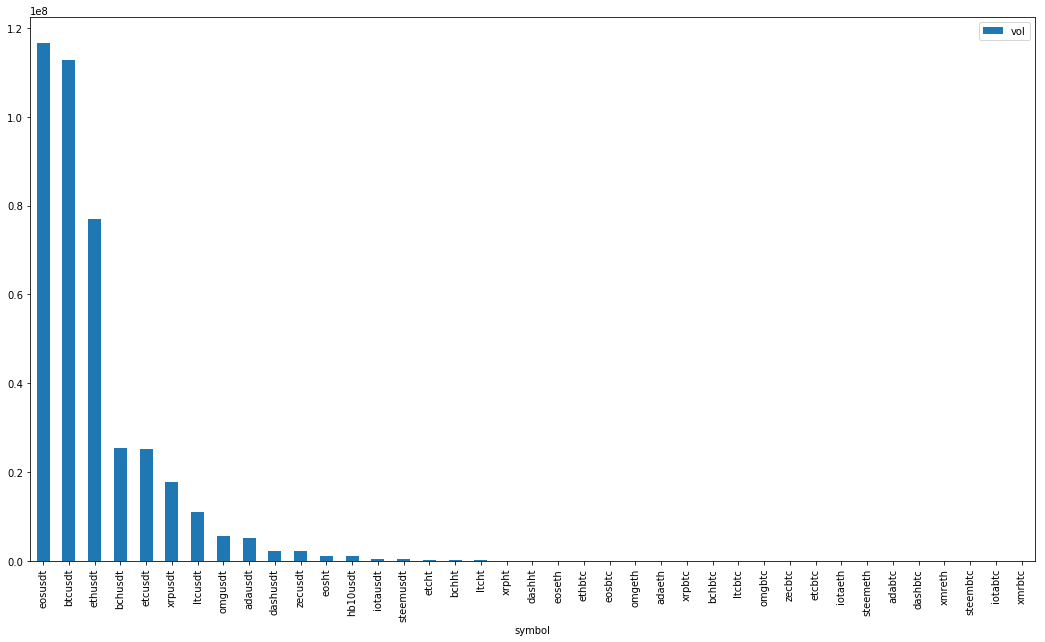

In [71]:
main_detail_df.sort_values(by='vol', ascending=False).plot(figsize=figsize, kind='bar', x='symbol', y='vol')

# Amount of symbols for the last 24H

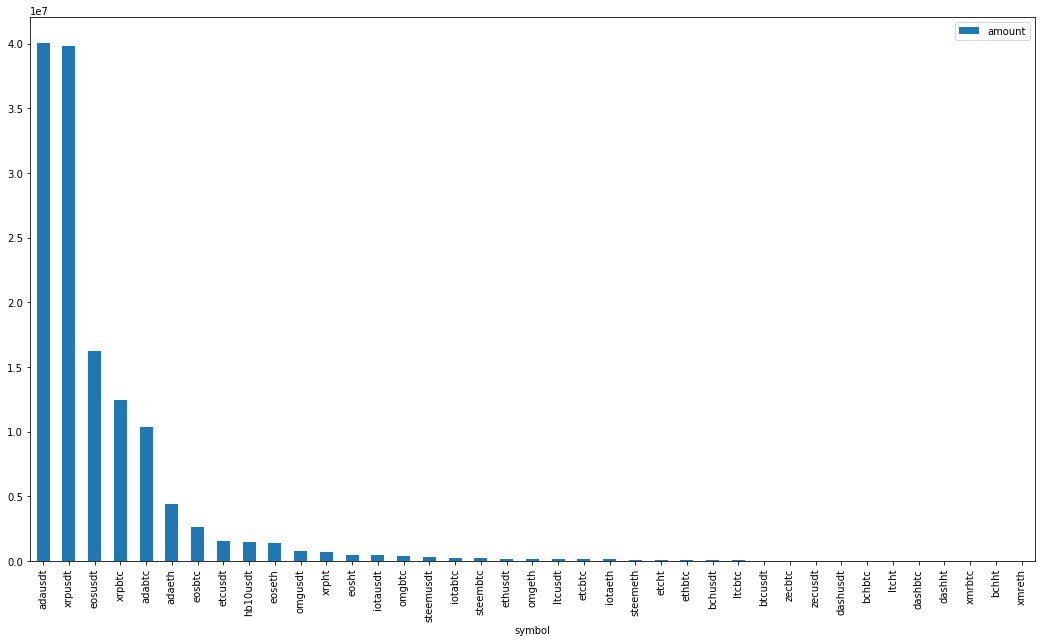

In [72]:
main_detail_df.sort_values(by='amount', ascending=False).plot(figsize=figsize, kind='bar', x='symbol', y='amount')

# Volumes for the last 24H

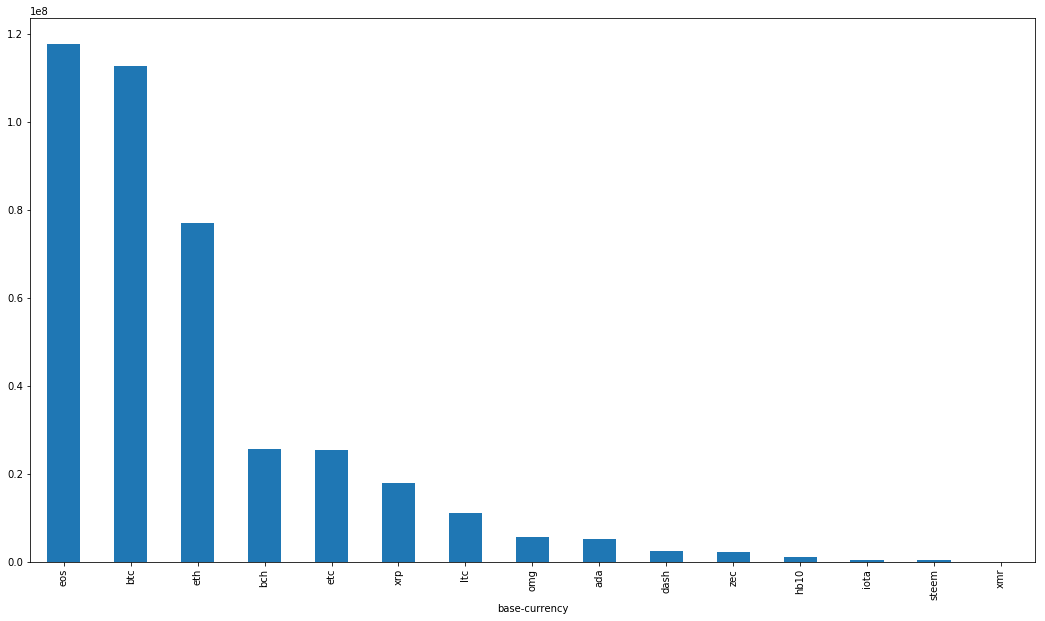

In [67]:
volumes = main_detail_df.groupby(['base-currency'])['vol'].sum()
volumes
volumes.sort_values(ascending=False).plot(figsize=figsize, kind='bar')

In [9]:
import datetime
def toHour(id):
    return datetime.datetime.fromtimestamp(id).hour

In [10]:
buy_fee = 0.002
sell_fee = 0.002

# Day trading strategy
Buy at the hour with min close price, and sell at hour with max close price every single day.

In [7]:
import random

def get_price(open_price, close_price):
    if open_price > close_price:
        return random.uniform(close_price, open_price)
    else:
        return random.uniform(open_price, close_price)

def day_trade_strategy(symbol, size, principle, train_quantil):
    kline = get_kline(symbol, '60min', size)
    df = pd.DataFrame(kline['data'])

    hours = df['id'].apply(toHour)
    df['hour'] = hours
    df.sort_values(by=['id'], inplace=True)
    trainsize = int(size * train_quantil)
    testsize = size - trainsize
    traindf = df.head(trainsize)
    testdf = df.tail(testsize)
    print(len(traindf))
    print(len(testdf))
    hour_grp_close_mean = traindf.groupby(['hour'])['close'].mean()
    print(hour_grp_close_mean)
    buy_hour = hour_grp_close_mean.idxmin()
    sell_hour = hour_grp_close_mean.idxmax()
    first = True
    buy_points = []
    sell_points = []
    fee = 0
    for index, row in testdf.iterrows():
        hour = row['hour']
        price = get_price(row['open'], row['close'])
        if hour == buy_hour:
            buy_points.append(price)
            first = False
        elif hour == sell_hour:
            if first == False:
                sell_points.append(price)
    min_len = min(len(buy_points), len(sell_points))
    buy_points = buy_points[0:min_len-1]
    sell_points = sell_points[0:min_len-1]
    print("Buy point count: {0}, sell point count: {1}".format(len(buy_points), len(sell_points)))
    buy_sell_zip = zip(buy_points, sell_points)
    x = [i for i in range(min_len-1)]
    plt.yscale('linear')
    plt.plot(x, buy_points, 'green')
    plt.plot(x, sell_points, 'red')
    plt.show()
    p = principle
    for pair in list(buy_sell_zip):
        b = pair[0]
        s = pair[1]
        base = round(p * (1 - buy_fee) / b, 4)
        p = s * base * (1-buy_fee)
    roi = round(p/principle, 4)
    return buy_hour, sell_hour, p, roi
    

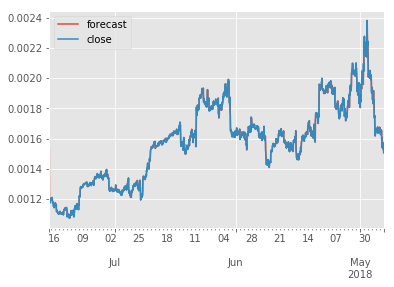

In [65]:
from statsmodels.tsa.arima_model import ARMA

# Forecast the first AR(1) model
close_price = eosbtc_df['close']
mod = ARMA(close_price, order=(1,0))
res = mod.fit()
res.plot_predict(start=close_price.index[0], end=close_price.index[1999])
plt.show()

In [39]:
eosbtc_df = get_kline_df('eosbtc', '60min', 2000)
eosbtc_df['26 ema'] = pd.ewma(eosbtc_df["close"], span=26)
eosbtc_df['12 ema'] = pd.ewma(eosbtc_df["close"], span=12)
eosbtc_df['MACD'] = eosbtc_df['12 ema'] - eosbtc_df['26 ema']
eosbtc_df['Signal'] = pd.ewma(eosbtc_df['MACD'], span=9)
eosbtc_df['Crossover'] = eosbtc_df['MACD'] - eosbtc_df['Signal']

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=9,min_periods=0,adjust=True,ignore_na=False).mean()
  """


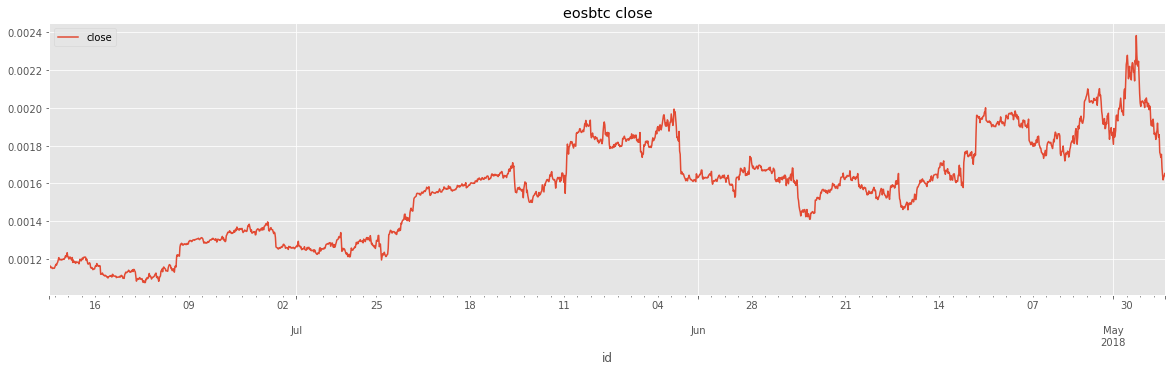

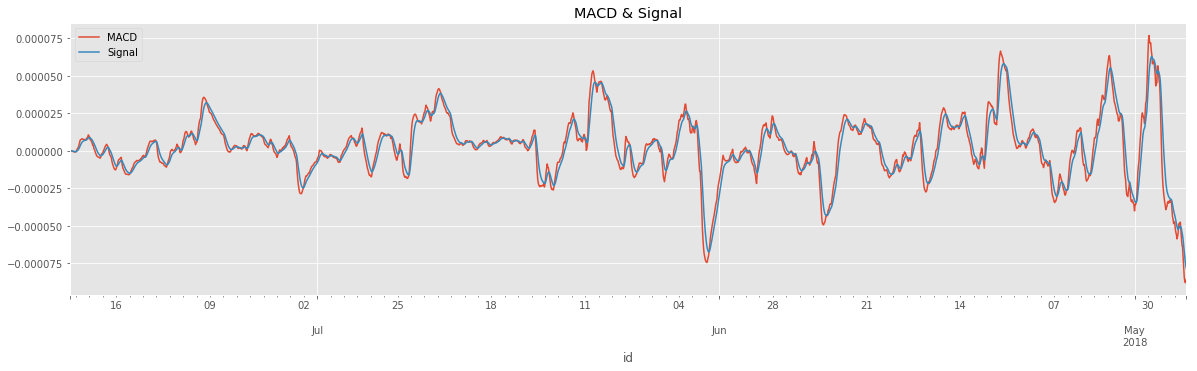

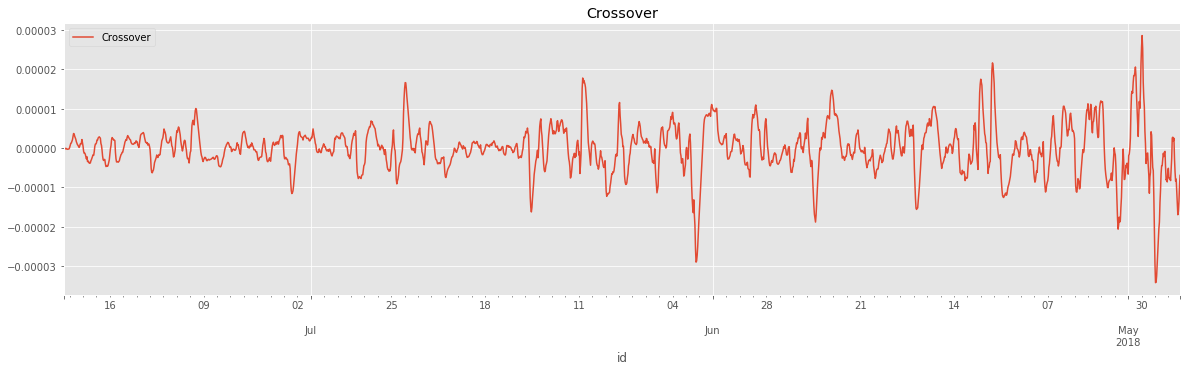

In [40]:
eosbtc_df.plot(y= ['close'], title='eosbtc close', figsize=(20, 5))
eosbtc_df.plot(y= ['MACD', 'Signal'], title='MACD & Signal', figsize=(20, 5))
eosbtc_df.plot(y= ['Crossover'], title='Crossover', figsize=(20, 5))

In [13]:
btcusdt_df = get_kline_df('btcusdt', '60min', 2000)

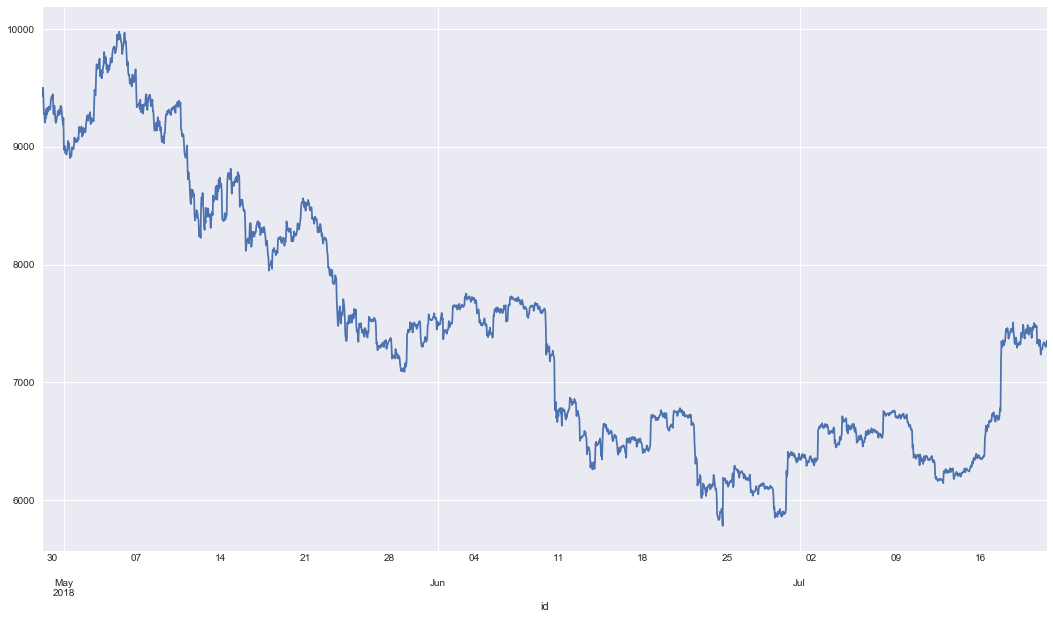

In [14]:
btcusdt_df['close'].plot(grid=True, figsize=figsize)

In [100]:
btcusdt_df['26 ema'] = pd.rolling_mean(btcusdt_df["close"], window=26)
btcusdt_df['12 ema'] = pd.rolling_mean(btcusdt_df["close"], window=12)

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).mean()
  """Entry point for launching an IPython kernel.
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  


In [101]:
btcusdt_df[['close', '26 ema', '12 ema']].tail()

,close,26 ema,12 ema
id,,,
2018-04-28 06:00:00,9169.07,9355.821538,9274.247500
2018-04-28 05:00:00,9157.85,9344.859231,9262.240000
2018-04-28 04:00:00,9132.20,9330.674615,9246.870000
2018-04-28 03:00:00,9147.50,9319.847692,9229.405000
2018-04-28 02:00:00,9053.65,9303.741154,9209.500833


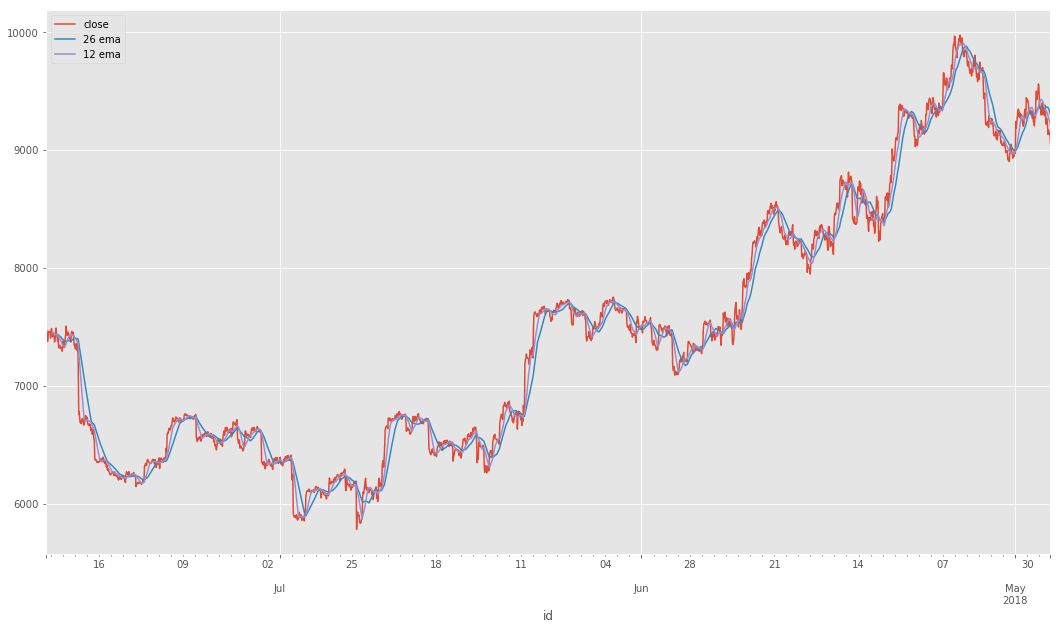

In [102]:
btcusdt_df[['close', '26 ema', '12 ema']].plot(grid=True, figsize=figsize)

In [103]:
btcusdt_df['12-26'] = btcusdt_df['12 ema'] - btcusdt_df['26 ema']
btcusdt_df['12-26'].tail()

id
2018-04-28 06:00:00   -81.574038
2018-04-28 05:00:00   -82.619231
2018-04-28 04:00:00   -83.804615
2018-04-28 03:00:00   -90.442692
2018-04-28 02:00:00   -94.240321
Name: 12-26, dtype: float64

In [121]:
SD = 5
btcusdt_df['regime'] = np.where(btcusdt_df['12-26'] > SD, 1, 0)
btcusdt_df['regime'] = np.where(btcusdt_df['12-26'] < -SD, -1, btcusdt_df['regime'])
btcusdt_df['regime'].value_counts()

 1    985
-1    869
 0    146
Name: regime, dtype: int64

(-1.1, 1.1)

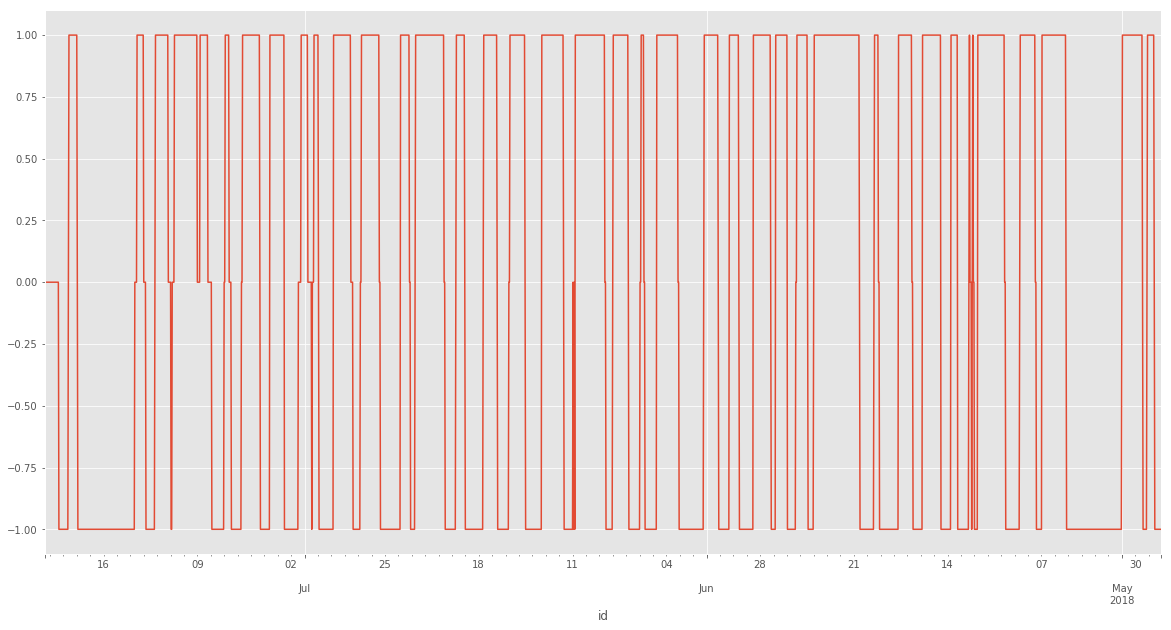

In [122]:
btcusdt_df['regime'].plot(lw=1.5)
plt.ylim([-1.1, 1.1])

In [125]:
btcusdt_df['market'] = np.log(btcusdt_df['close'] / btcusdt_df['close'].shift(1))
btcusdt_df['strategy'] = btcusdt_df['regime'].shift(1) * btcusdt_df['market']

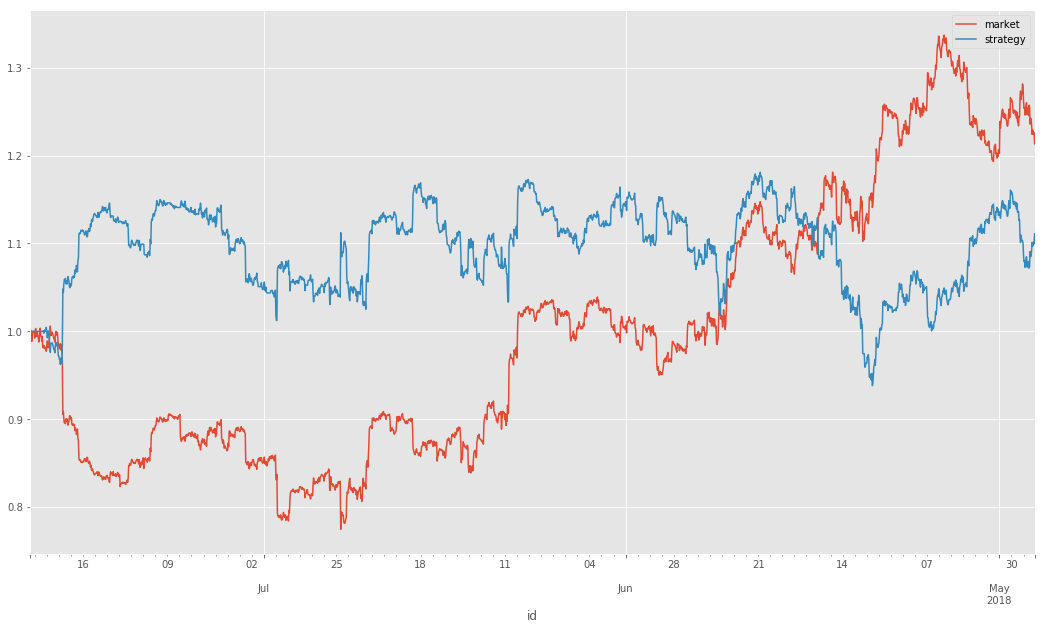

In [126]:
btcusdt_df[['market', 'strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=figsize)

In [120]:
btcusdt_df['strategy'].describe()

/Users/magiclane/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


count    1353.000000
mean            -inf
std              NaN
min             -inf
25%              NaN
50%              NaN
75%        -5.936159
max        -2.795854
Name: strategy, dtype: float64

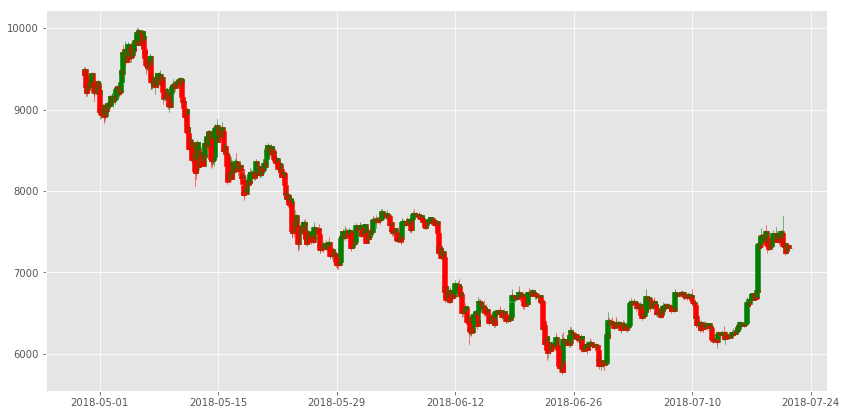

In [7]:
import matplotlib.finance as mpf
fig, ax = plt.subplots(figsize=(14, 7))
qutotes = []
for index, (d, o, c, h, l) in enumerate(zip(btcusdt_df.index,
                                            btcusdt_df.open, btcusdt_df.close,
                                            btcusdt_df.high, btcusdt_df.low)):
    d = mpf.date2num(d)
    val = (d, o, c, h, l)
    qutotes.append(val)
mpf.candlestick_ochl(ax, qutotes, width=0.6, colorup='green', colordown='red')
ax.autoscale_view()
ax.xaxis_date()

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  after removing the cwd from sys.path.


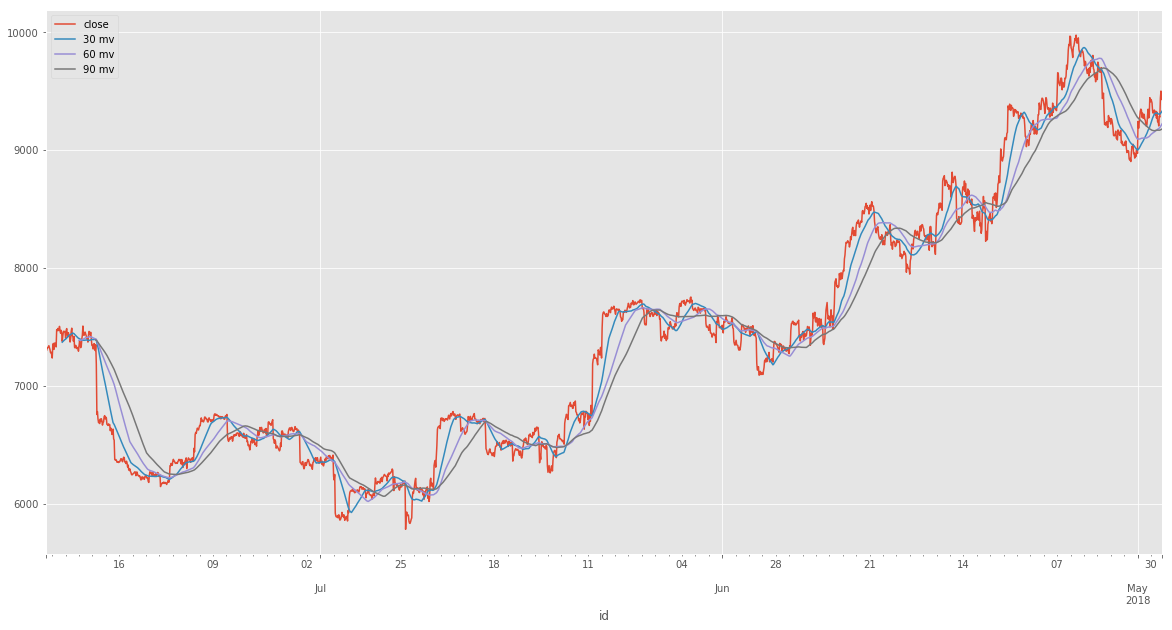

In [8]:
btcusdt_df.close.plot()
pd.rolling_mean(btcusdt_df.close, window=30).plot()
pd.rolling_mean(btcusdt_df.close, window=60).plot()
pd.rolling_mean(btcusdt_df.close, window=90).plot()
plt.legend(['close', '30 mv', '60 mv', '90 mv'], loc='best')

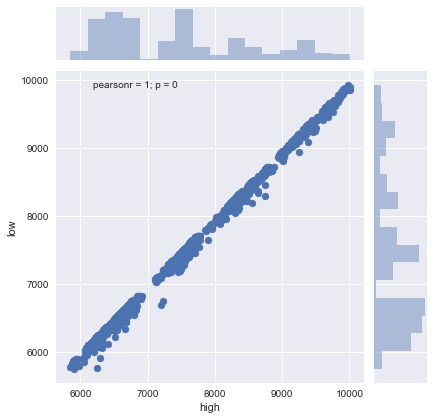

In [10]:
import seaborn as sns
sns.jointplot(btcusdt_df['high'], btcusdt_df['low'])

In [17]:
cs_max = btcusdt_df.close.max()
cs_min = btcusdt_df.close.min()

sp382 = (cs_max - cs_min) * 0.382 + cs_min
sp618 = (cs_max - cs_min) * 0.618 + cs_min
print("382: " + str(round(sp382, 2)))
print("618: " + str(round(sp618, 2)))

382: 7383.68
618: 8373.63


In [15]:
from scipy import stats
sp382_stats = stats.scoreatpercentile(btcusdt_df.close, 38.2)
sp618_stats = stats.scoreatpercentile(btcusdt_df.close, 61.8)
print("382: " + str(round(sp382_stats, 2)))
print("618: " + str(round(sp618_stats, 2)))

382: 6714.85
618: 7556.66


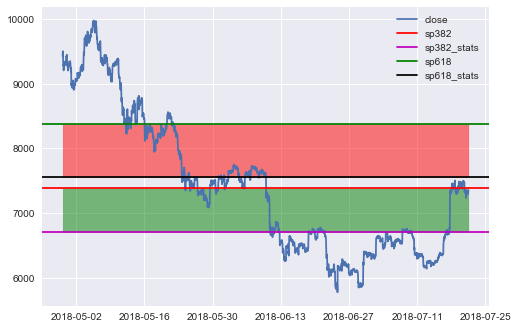

In [18]:
from collections import namedtuple

def plot_golden():
    above618 = np.maximum(sp618, sp618_stats)
    below618 = np.minimum(sp618, sp618_stats)
    above382 = np.maximum(sp382, sp382_stats)
    below382 = np.minimum(sp382, sp382_stats)
    
    plt.plot(btcusdt_df.close)
    plt.axhline(sp382, c='r')
    plt.axhline(sp382_stats, c='m')
    plt.axhline(sp618, c='g')
    plt.axhline(sp618_stats, c='k')
    
    plt.fill_between(btcusdt_df.index, above618, below618, alpha=0.5, color='r')
    plt.fill_between(btcusdt_df.index, above382, below382, alpha=0.5, color='g')
    
    return namedtuple('golden', ['above618', 'below618', 'above382', 'below382'])(
        above618, below618, above382, below382)
golden = plot_golden()
plt.legend(['close', 'sp382', 'sp382_stats', 'sp618', 'sp618_stats'], loc='best')

In [19]:
golden.above618 - golden.below382

1658.7833600000013

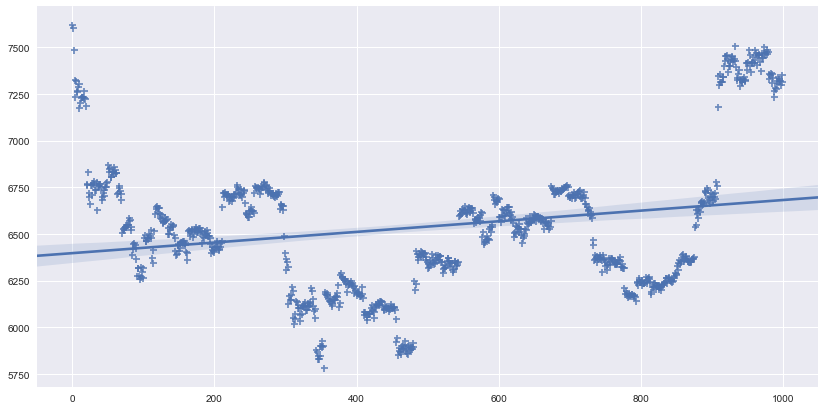

In [25]:
import seaborn as sns
sns.set_context(rc={'figure.figsize': (14, 7)})
df = btcusdt_df.tail(1000)
sns.regplot(x=np.arange(0, df.shape[0]), y=df.close.values, marker='+')
plt.show()

# Mean revertion

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e4b8588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ec7dba8>], dtype=object)

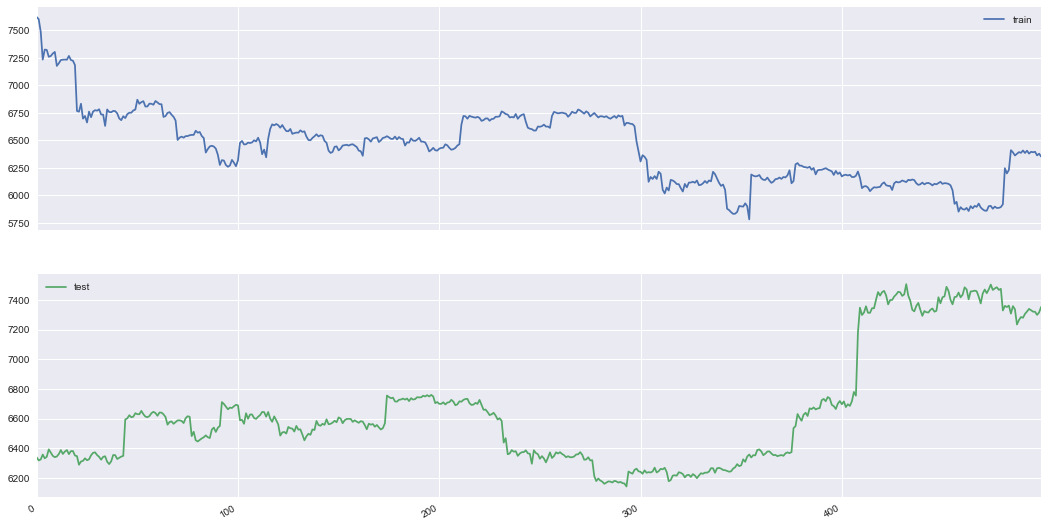

In [33]:
train_df = btcusdt_df[1000:1500]
test_df = btcusdt_df[1500:]
tmp_df = pd.DataFrame(np.array([train_df.close.values, test_df.close.values]).T, columns=['train', 'test'])
tmp_df[['train', 'test']].plot(subplots=True, grid=True, figsize=figsize)

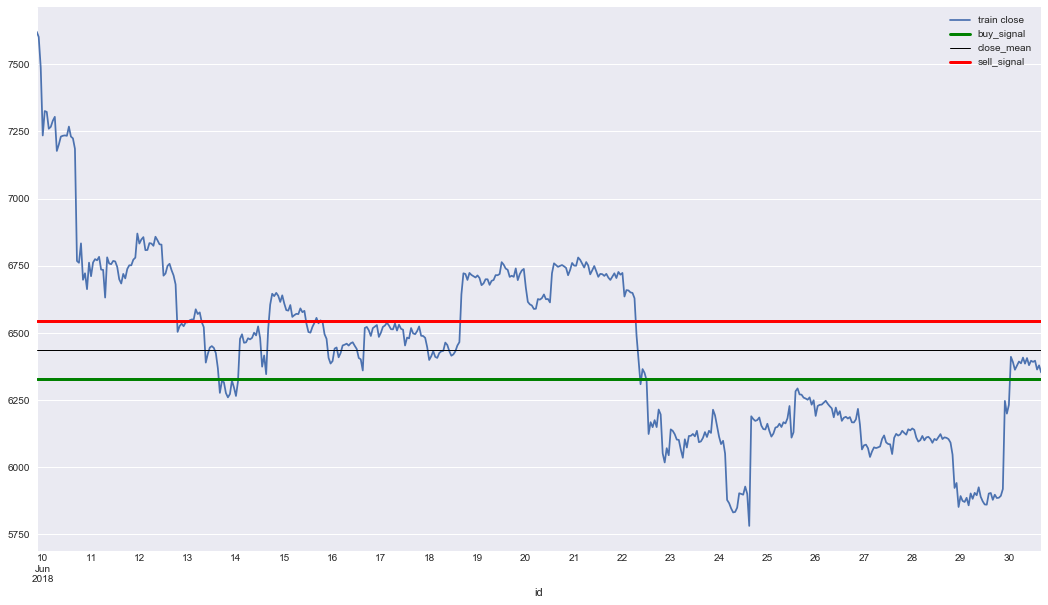

In [34]:
close_mean = train_df.close.mean()
close_std = train_df.close.std()

#sell
sell_signal = close_mean +  close_std / 3
#buy
buy_signal = close_mean - close_std / 3

plt.figure(figsize=figsize)
train_df.close.plot()
plt.axhline(buy_signal, color='g', lw=3)
plt.axhline(close_mean, color='black', lw=1)
plt.axhline(sell_signal, color='r', lw=3)
plt.legend(['train close', 'buy_signal', 'close_mean', 'sell_signal'], loc='best')
plt.show()

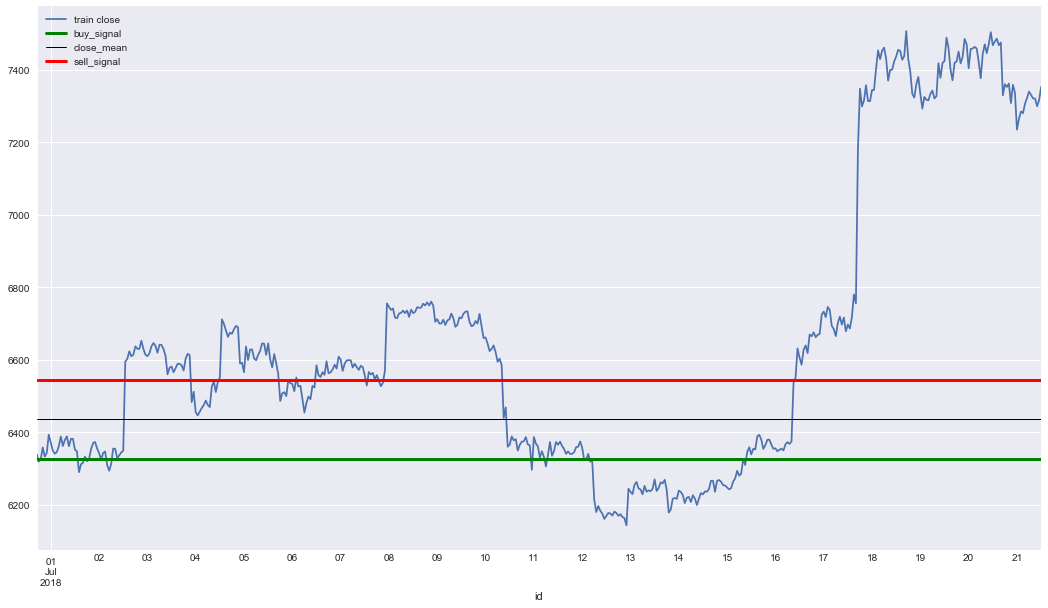

In [35]:
plt.figure(figsize=figsize)
test_df.close.plot()
plt.axhline(buy_signal, color='g', lw=3)
plt.axhline(close_mean, color='black', lw=1)
plt.axhline(sell_signal, color='r', lw=3)
plt.legend(['train close', 'buy_signal', 'close_mean', 'sell_signal'], loc='best')
plt.show()

In [36]:
buy_index = test_df[test_df['close'] <= buy_signal].index
test_df.loc[buy_index, 'signal'] = 1

sell_index = test_df[test_df['close'] >= sell_signal].index
test_df.loc[sell_index, 'sinal'] = 0

test_df['keep'] = test_df['sinal']
test_df['keep'].fillna(method='ffill', inplace=True)

/Users/magiclane/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/magiclane/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11353e2b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ed7c550>], dtype=object)

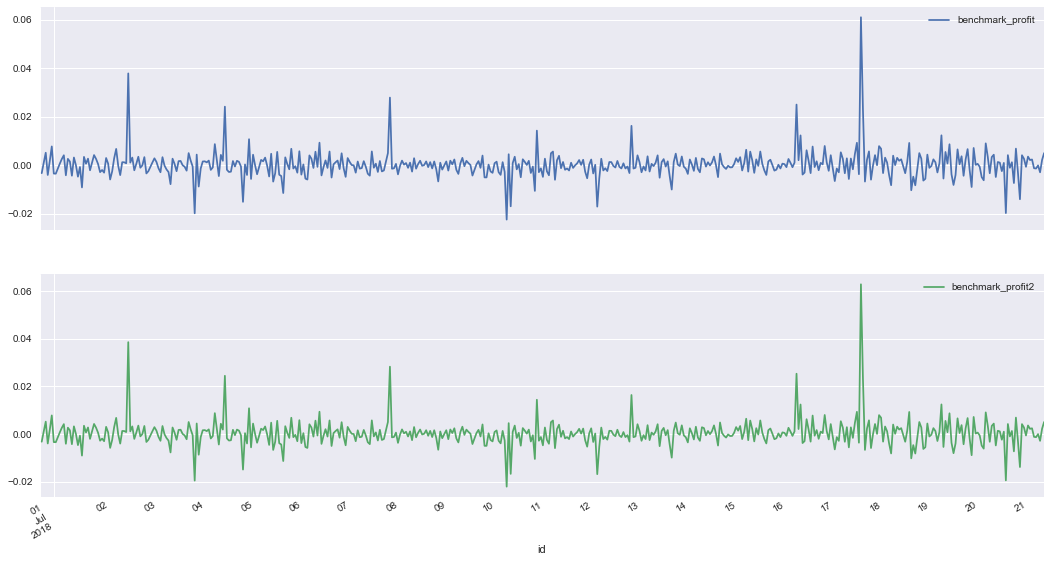

In [37]:
test_df['benchmark_profit'] = np.log(test_df['close'] / test_df['close'].shift(1))

test_df['benchmark_profit2'] = test_df['close'] / test_df['close'].shift(1) - 1

test_df[['benchmark_profit', 'benchmark_profit2']].plot(subplots=True, grid=True, figsize=figsize)

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


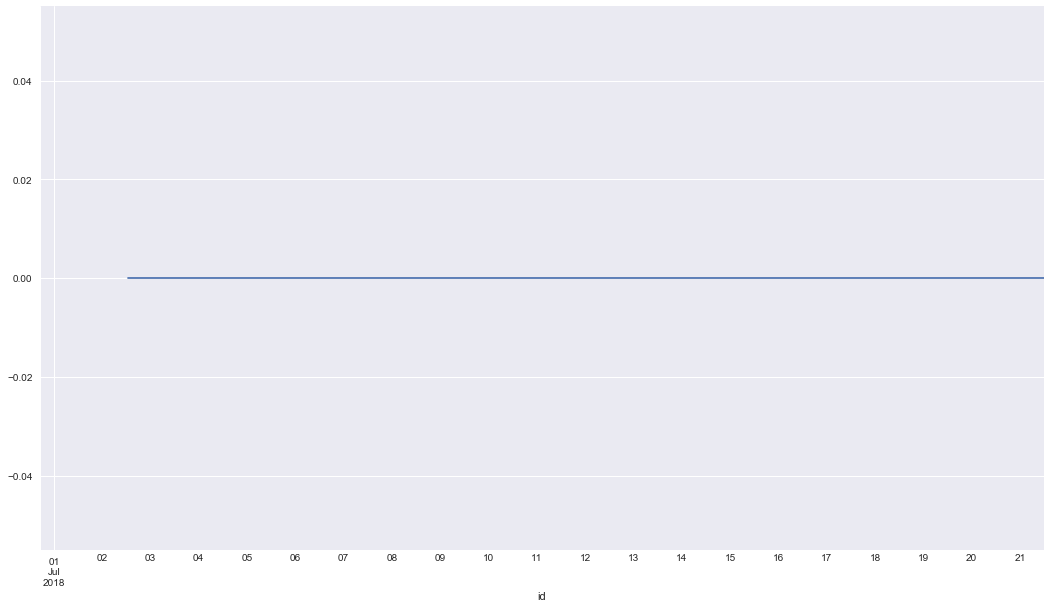

In [41]:
test_df['trend_profit'] = test_df['keep'] * test_df['benchmark_profit']
test_df['trend_profit'].plot(figsize=figsize)

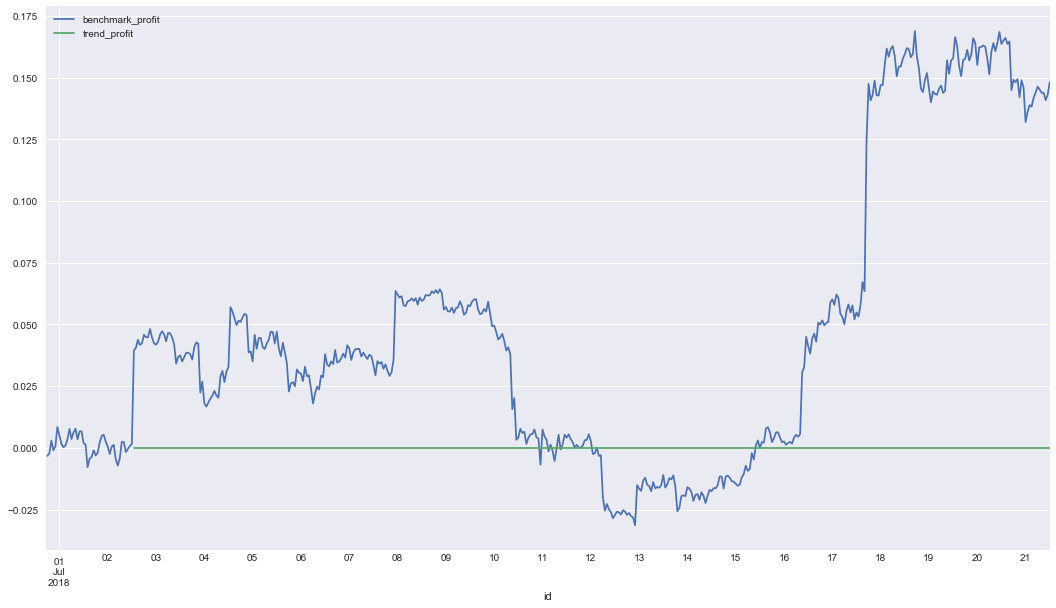

In [42]:
test_df[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True, figsize=figsize)

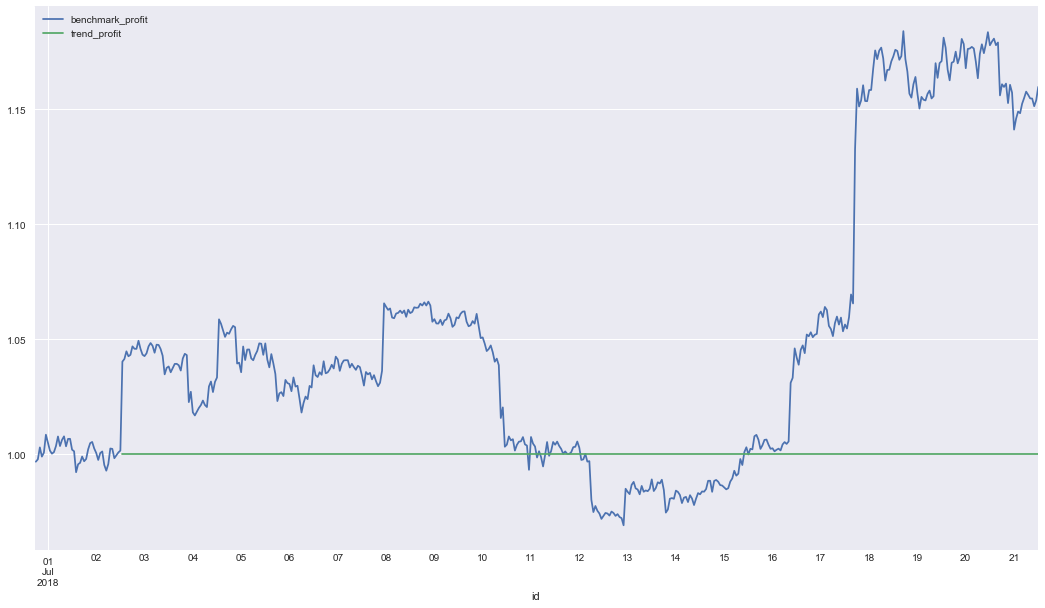

In [43]:
test_df[['benchmark_profit', 'trend_profit']].cumsum().apply(np.exp).plot(grid=True, figsize=figsize)

In [9]:
from abupy import AbuFactorBuyXD
from abupy import BuyCallMixin
class AbuFactorBuyBreak(AbuFactorBuyXD, BuyCallMixin):
    """示例继承AbuFactorBuyXD完成正向突破买入择时类, 混入BuyCallMixin，即向上突破触发买入event"""
    def fit_day(self, today):
        """
        针对每一个交易日拟合买入交易策略，寻找向上突破买入机会
        :param today: 当前驱动的交易日金融时间序列数据
        :return:
        """
        # 今天的收盘价格达到xd天内最高价格则符合买入条件
        if today.close == self.xd_kl.close.max():
            # 生成买入订单, 由于使用了今天的收盘价格做为策略信号判断，所以信号发出后，只能明天买
            return self.buy_tomorrow()
        return None

In [12]:
from abupy import AbuBenchmark
from abupy import AbuCapital
# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)

In [15]:
from abupy import ABuPickTimeExecute
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTESLA'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            None,
                                                                            capital, show=True)

In [17]:
from abupy import AbuFactorSellXD
class AbuFactorSellBreak(AbuFactorSellXD):
    """示例继承AbuFactorBuyXD, 向下突破卖出择时因子"""
    def support_direction(self):
        """支持的方向，只支持正向"""
        return [ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        """
        寻找向下突破作为策略卖出驱动event
        :param today: 当前驱动的交易日金融时间序列数据
        :param orders: 买入择时策略中生成的订单序列
        """
        # 今天的收盘价格达到xd天内最低价格则符合条件
        if today.close == self.xd_kl.close.min():
            for order in orders:
                self.sell_tomorrow(order)

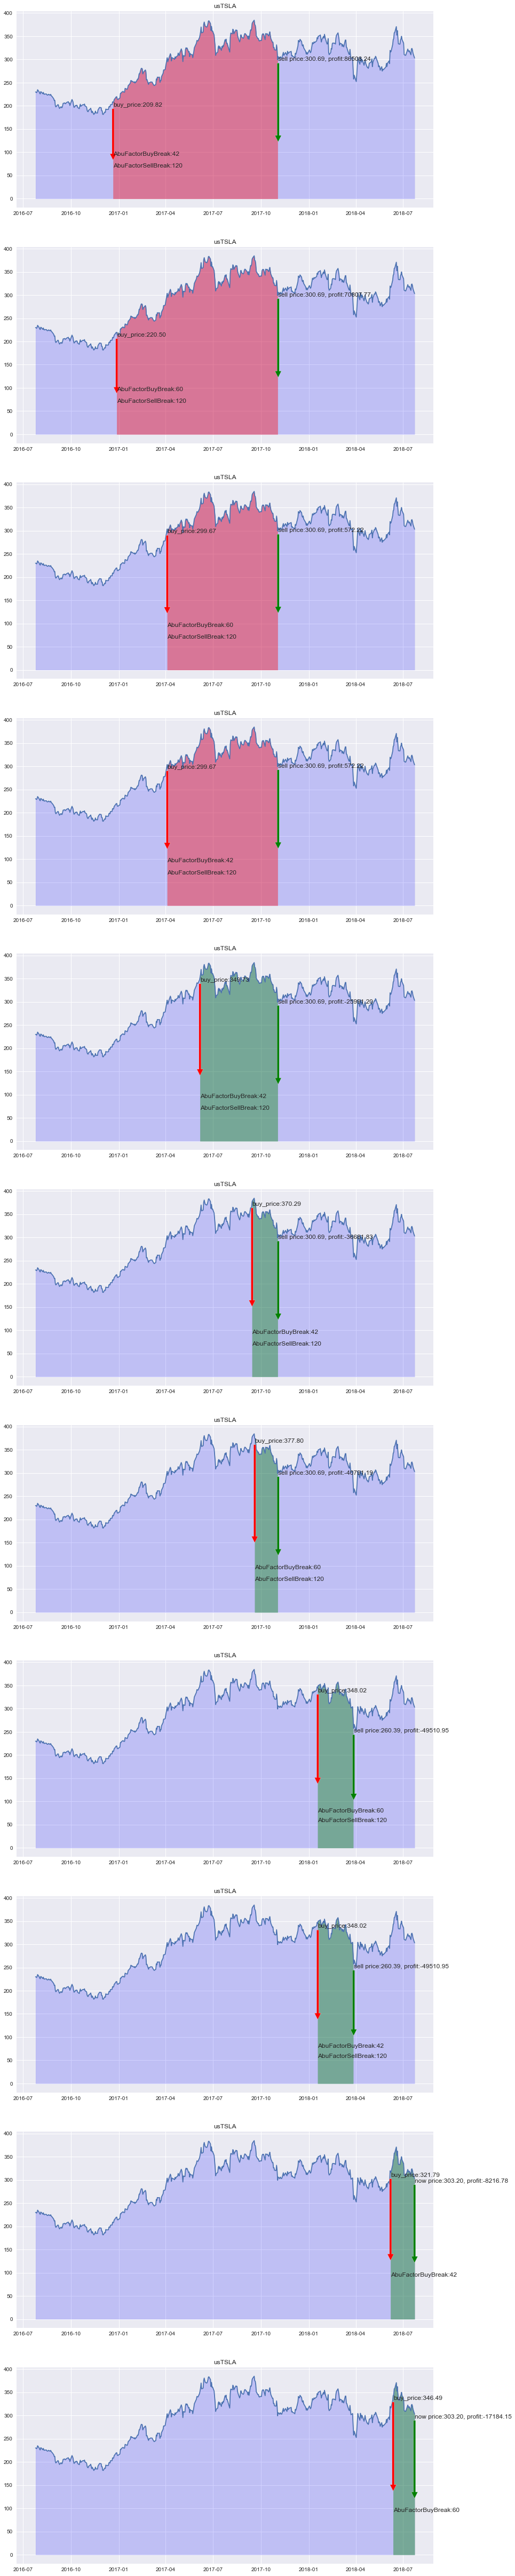

In [19]:
from abupy import ESupportDirection
# 使用120天向下突破为卖出信号
sell_factor1 = {'xd': 120, 'class': AbuFactorSellBreak}

# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 只使用120天向下突破为卖出因子
sell_factors = [sell_factor1]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            sell_factors,
                                                                            capital, show=True)

In [15]:
btcusdt = get_kline_df("btcusdt", '60min', 500)

In [166]:
candle_to_sell = 50
candle_to_buy = 20
stop_win = 3
stop_loss = 0.5
commission_rate = 0.02
capital = 100000 / 6.67
transaction_price = 0
transaction_volume = 0

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).max()
  """Entry point for launching an IPython kernel.
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_min is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).min()
  


capital: 14992.503748125937
buy: 6645.73, volume: 2.256, capital: 14992.766879999997
sell: 6636.8, volume: 2.256, capital: 14972.620799999999
buy: 6649.08, volume: 2.252, capital: 14973.728159999999
sell: 6638.16, volume: 2.252, capital: 14949.136319999998
buy: 6518.31, volume: 2.293, capital: 14946.484830000001
sell: 6522.15, volume: 2.293, capital: 14955.28995
buy: 6523.64, volume: 2.292, capital: 14952.18288
sell: 6529.18, volume: 2.292, capital: 14964.88056
buy: 6538.05, volume: 2.289, capital: 14965.596450000001
sell: 6527.45, volume: 2.289, capital: 14941.333050000001
buy: 6643.4, volume: 2.249, capital: 14941.0066
sell: 6721.94, volume: 2.249, capital: 15117.64306
buy: 6723.24, volume: 2.249, capital: 15120.56676
sell: 6715.73, volume: 2.249, capital: 15103.67677
buy: 6763.37, volume: 2.233, capital: 15102.60521
sell: 6754.0, volume: 2.233, capital: 15081.682
buy: 6759.03, volume: 2.231, capital: 15079.395929999999
sell: 6752.7, volume: 2.231, capital: 15065.273699999998
buy: 67

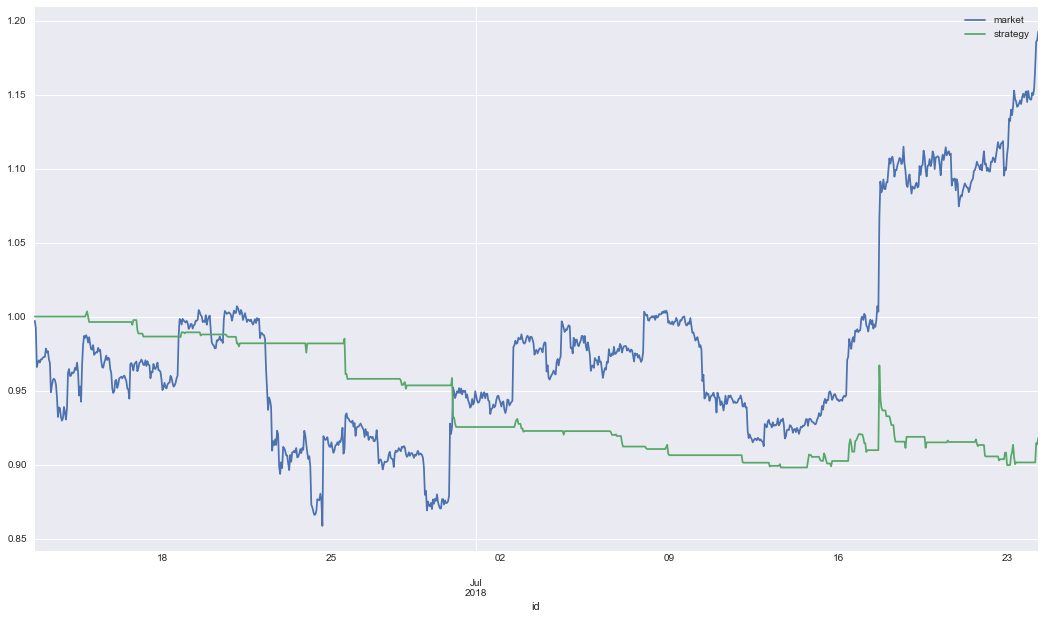

In [167]:
btcusdt['last_n_high'] = pd.rolling_max(btcusdt.close, candle_to_buy)
btcusdt['last_m_low'] = pd.rolling_min(btcusdt.close, candle_to_sell)

# btcusdt['regime'] = np.where(btcusdt.close >= btcusdt.last_n_high.shift(1), 1, 0)
# btcusdt['regime'] = np.where(btcusdt.close <= btcusdt.last_m_low.shift(1), -1, btcusdt['regime'])
print("capital: " + str(capital))
regime = [0 for i in range (max(candle_to_buy, candle_to_sell)+1)]
for index, row in btcusdt[max(candle_to_buy, candle_to_sell):-1].iterrows():
    close = row['close']
    lh = row['last_n_high']
    ll = row['last_m_low']
    atr = abs(lh - ll)
    if capital != 0: # buy
        if close >= lh:
            transaction_price = close
            transaction_volume = np.round(capital/close, 3)
            capital = 0
            regime.append(1)
            print("buy: {0}, volume: {1}, capital: {2}".format(close, transaction_volume, close*transaction_volume))
        else:
            regime.append(0)
    elif capital == 0: # sell
        if close <= ll \
            or (close - transaction_price >=  stop_win*atr or transaction_price-close <= stop_loss*atr):
            
            capital = transaction_volume * close
            print("sell: {0}, volume: {1}, capital: {2}".format(close, transaction_volume, close*transaction_volume))
            transaction_price = close
            transaction_volume = 0
            regime.append(-1)
            
        else:
            regime.append(0)
    else:
        regime.append(1)

btcusdt['regime'] = regime
if capital == 0:
    capital = transaction_price * transaction_volume * 6.67
print(capital)
btcusdt['market'] = np.log(btcusdt['close'] / btcusdt['close'].shift(1))
btcusdt['strategy'] = btcusdt['regime'].shift(1) * btcusdt['market']

btcusdt[['market', 'strategy']].cumsum(skipna=True).apply(np.exp).plot(grid=True, figsize=figsize)

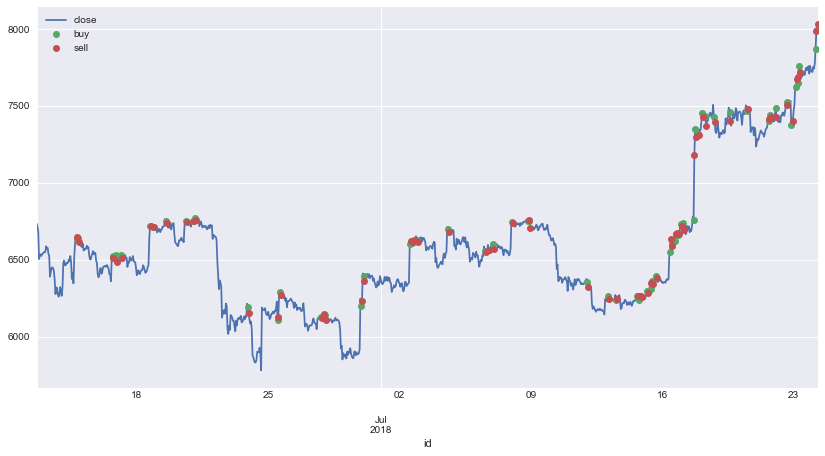

In [168]:
btcusdt['close'].plot()
btcusdt[btcusdt['regime'] == 1]['close'].plot(style='o')
btcusdt[btcusdt['regime'] == -1]['close'].plot(style='o')
plt.legend(['close', 'buy', 'sell'], loc='best')

# Mean reversion

In [5]:
btcusdt = get_kline_df("btcusdt", '60min', 2000)

NameError: name 'pd' is not defined

In [ ]:
stop_loss = 0.01
stop_win = 0.03
commission_rate = 0.02
origin = 100000 / 6.67
capital = 100000 / 6.67
transaction_price = 0
transaction_volume = 0
slow_period = 24
fast_period = 12

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False,axis=0).mean()
  """


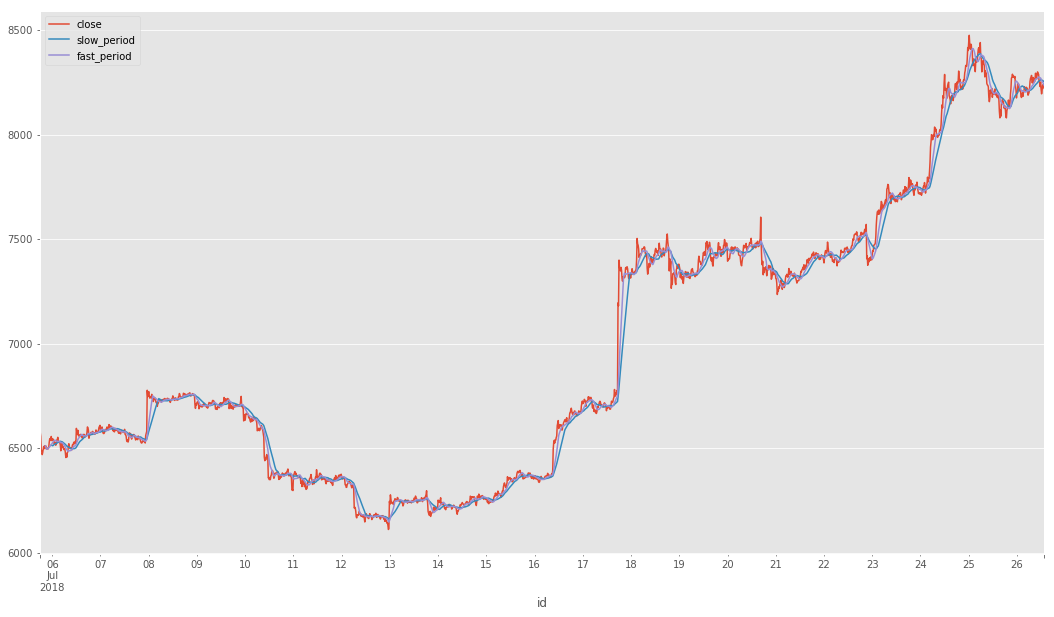

In [55]:
from statsmodels import api as sm, regression
btcusdt['slow_period'] = pd.rolling_mean(btcusdt.close, window=slow_period)
btcusdt['fast_period'] = pd.rolling_mean(btcusdt.close, window=fast_period)

btcusdt['slow_reg'] = pd.rolling_window(btcusdt.close, window=slow_period)

btcusdt['regime'] = np.where(btcusdt.fast_period > btcusdt.slow_period.shift(1), 1, 0)
btcusdt['regime'] = np.where(btcusdt.fast_period < btcusdt.slow_period.shift(1), -1, btcusdt['regime'])

btcusdt[['close', 'slow_period', 'fast_period']].plot(figsize=figsize)

capital: 14992.503748125937
buy: 6536.07, volume: 2.294, capital: 14993.74458
sell: 6542.8, volume: 2.294, capital: 15009.183200000001
buy: 6543.95, volume: 2.294, capital: 15011.8213
sell: 6541.32, volume: 2.294, capital: 15005.78808
buy: 6533.64, volume: 2.297, capital: 15007.771080000002
sell: 6520.5, volume: 2.297, capital: 14977.588500000002
buy: 6527.35, volume: 2.295, capital: 14980.268250000001
sell: 6520.44, volume: 2.295, capital: 14964.4098
buy: 6513.75, volume: 2.297, capital: 14962.083750000002
sell: 6523.95, volume: 2.297, capital: 14985.51315
buy: 6538.59, volume: 2.292, capital: 14986.448279999999
sell: 6540.0, volume: 2.292, capital: 14989.679999999998
buy: 6551.62, volume: 2.288, capital: 14990.106559999998
sell: 6534.68, volume: 2.288, capital: 14951.347839999999
buy: 6529.0, volume: 2.29, capital: 14951.41
sell: 6531.35, volume: 2.29, capital: 14956.791500000001
buy: 6514.85, volume: 2.296, capital: 14958.0956
sell: 6513.94, volume: 2.296, capital: 14956.00623999999

buy: 6244.9, volume: 2.268, capital: 14163.433199999998
sell: 6260.0, volume: 2.268, capital: 14197.679999999998
buy: 6259.6, volume: 2.268, capital: 14196.772799999999
sell: 6255.65, volume: 2.268, capital: 14187.814199999997
buy: 6270.57, volume: 2.263, capital: 14190.299909999998
sell: 6261.84, volume: 2.263, capital: 14170.54392
buy: 6259.14, volume: 2.264, capital: 14170.69296
sell: 6238.99, volume: 2.264, capital: 14125.073359999999
buy: 6238.45, volume: 2.264, capital: 14123.850799999998
sell: 6244.88, volume: 2.264, capital: 14138.408319999999
buy: 6252.0, volume: 2.261, capital: 14135.772
sell: 6253.77, volume: 2.261, capital: 14139.773970000002
buy: 6246.68, volume: 2.264, capital: 14142.48352
sell: 6250.43, volume: 2.264, capital: 14150.97352
buy: 6248.42, volume: 2.265, capital: 14152.671300000002
sell: 6253.08, volume: 2.265, capital: 14163.226200000001
buy: 6262.64, volume: 2.262, capital: 14166.091680000001
sell: 6247.93, volume: 2.262, capital: 14132.81766
buy: 6259.34,

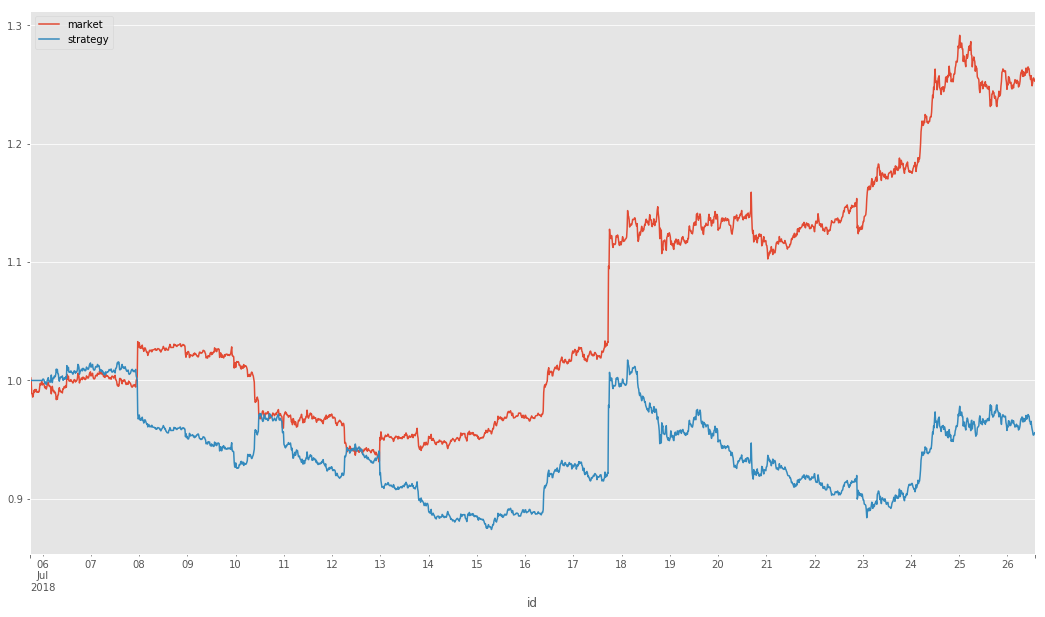

In [56]:
print("capital: " + str(capital))
for index, row in btcusdt[max(slow_period, fast_period):-1].iterrows():
    close = row['close']
    fast = row['fast_period']
    slow = row['slow_period']
    regime = row['regime']
    if capital != 0: # buy
        if regime == 1:
            transaction_price = close
            transaction_volume = np.round(capital/close, 3)
            capital = 0
            print("buy: {0}, volume: {1}, capital: {2}".format(close, transaction_volume, close*transaction_volume))
    elif capital == 0: # sell
        if regime == -1 \
            or (transaction_price*stop_loss < close) \
            or (transaction_price*stop_win > close):
            capital = transaction_volume * close
            print("sell: {0}, volume: {1}, capital: {2}".format(close, transaction_volume, close*transaction_volume))
            transaction_price = close
            transaction_volume = 0

if capital == 0:
    capital = transaction_price * transaction_volume
print(capital)
print("return rate: %.3f" % (capital / origin))
btcusdt['market'] = np.log(btcusdt['close'] / btcusdt['close'].shift(1))
btcusdt['strategy'] = btcusdt['regime'].shift(1) * btcusdt['market']

btcusdt[['market', 'strategy']].cumsum(skipna=True).apply(np.exp).plot(grid=True, figsize=figsize)

# Mean reversion and trending trade

In [184]:
import statsmodels.api as sm
from statsmodels import regression

def calc_regress_deg(y_arr, show=True):
    x = np.arange(0, len(y_arr))
    zoom_factor = x.max() / y_arr.max()
    y_arr = zoom_factor * y_arr
    
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y_arr, x).fit()
    rad = model.params[1]
    deg = np.rad2deg(rad)
    
    if show:
        intercept = model.params[0]
        reg_y_fit = x * rad + intercept
        plt.plot(x, y_arr)
        plt.plot(x, reg_y_fit)
        plt.title('deg = ' + str(deg))
        plt.show()
    return deg

In [185]:
btcusdt = get_kline_df("btcusdt", '60min', 1000)

In [209]:
stop_loss = 0.01
stop_win = 0.1
commission_rate = 0.002
origin = 100000 / 6.67
capital = 100000 / 6.67
transaction_price = 0
transaction_volume = 0
slow_period = 12
fast_period = 6
slow_deg_down = -5
slow_deg_up = 5
fast_deg_up = 5
fast_deg_down = -5
stance = 1

/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """Entry point for launching an IPython kernel.
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()
  
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
/Users/magiclane/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean(

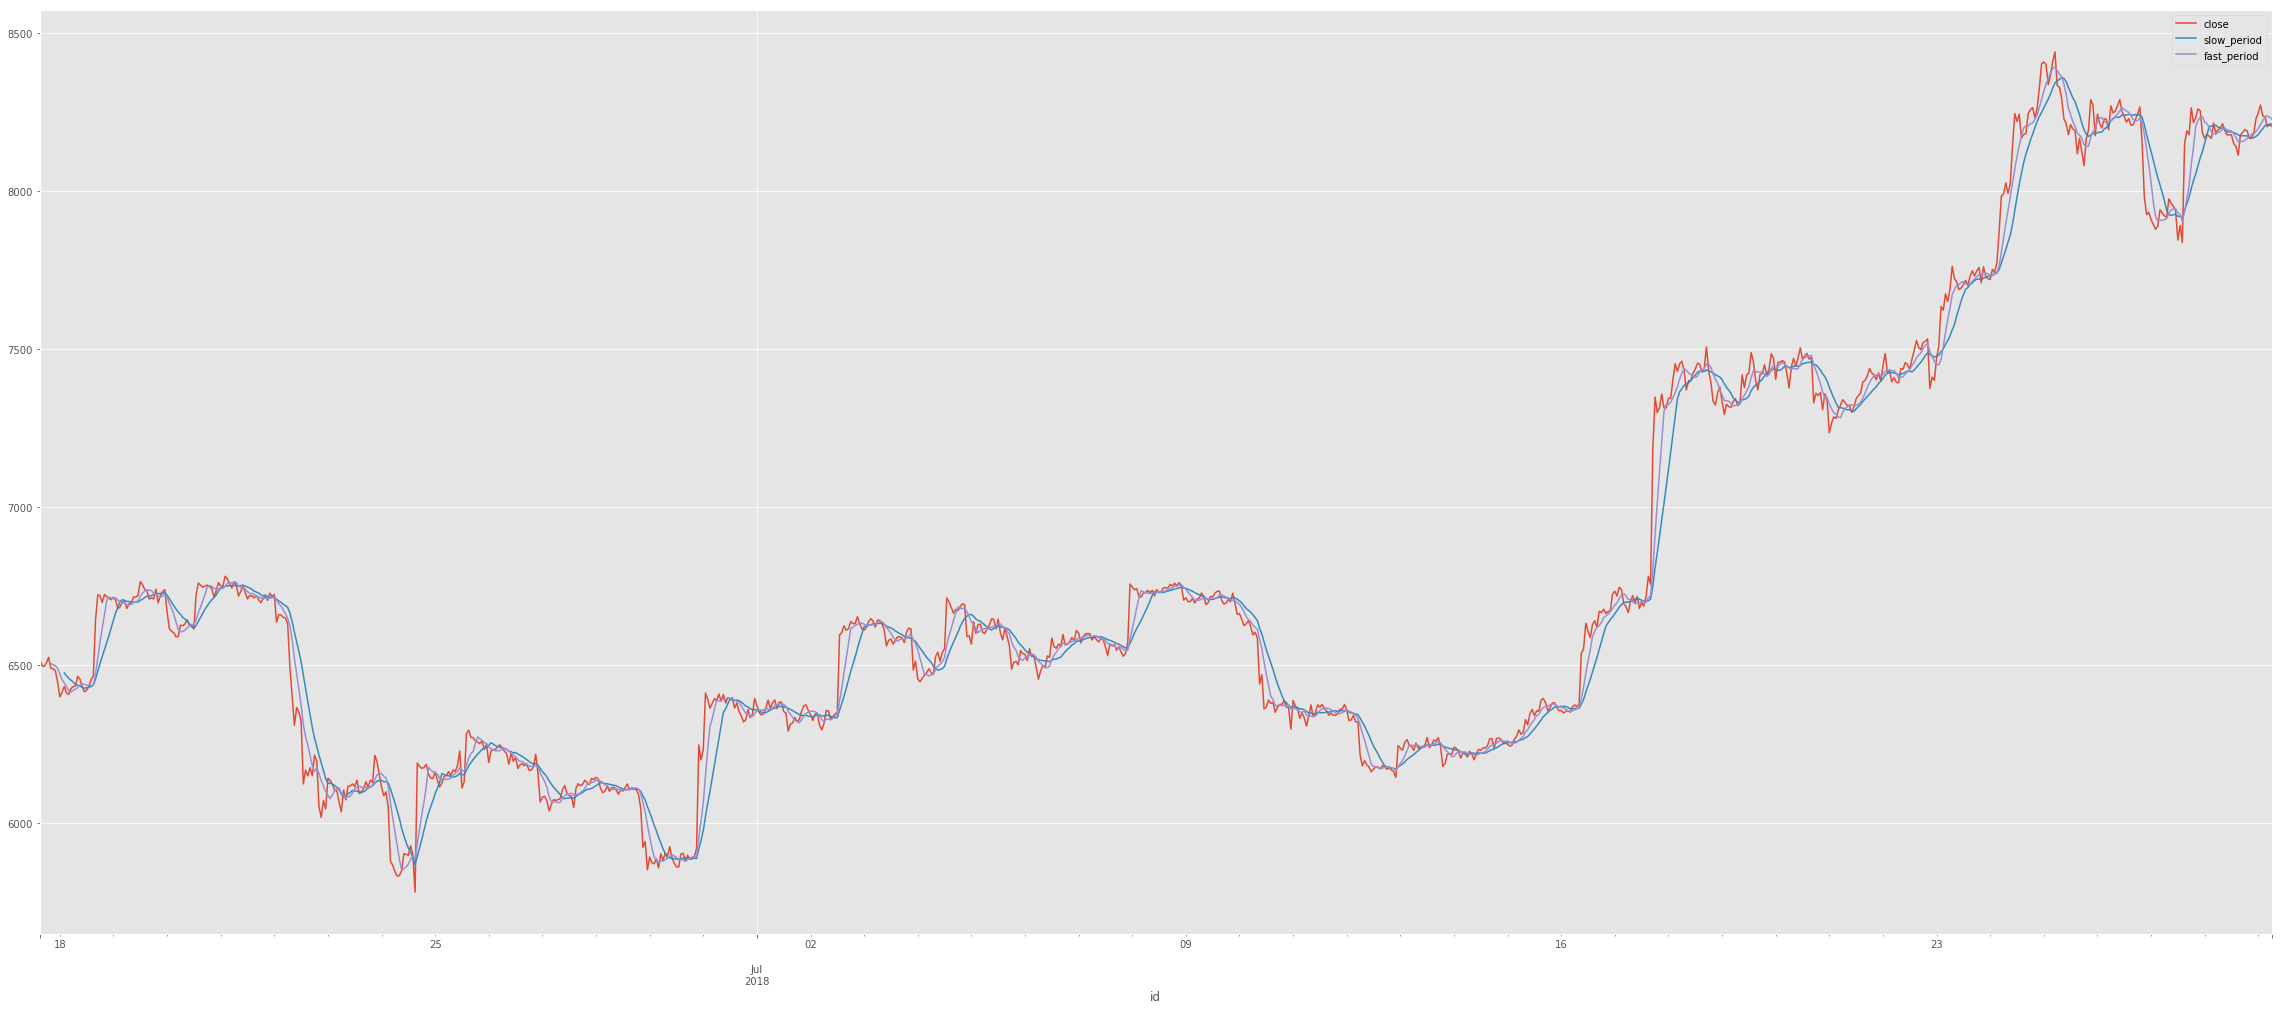

In [210]:
btcusdt['slow_period'] = pd.rolling_mean(btcusdt.close, window=slow_period)
btcusdt['fast_period'] = pd.rolling_mean(btcusdt.close, window=fast_period)

btcusdt['fast_slow'] = btcusdt['fast_period'] - btcusdt['slow_period']

btcusdt['slow_amount_avg'] = pd.rolling_mean(btcusdt.amount, window=slow_period)
btcusdt['fast_amount_avg'] = pd.rolling_mean(btcusdt.amount, window=fast_period)

btcusdt['regime'] = np.where(btcusdt.fast_slow > stance, 1, 0)
btcusdt['regime'] = np.where(btcusdt.fast_slow < -stance, -1, btcusdt['regime'])

btcusdt['commission'] = np.zeros(len(btcusdt))

btcusdt[['close', 'slow_period', 'fast_period']].plot(figsize=(40, 17))

In [211]:
slow_deg = [0 for i in range(slow_period)]
for i in range(slow_period, len(btcusdt)):
    deg = calc_regress_deg(btcusdt.iloc[i-slow_period:i]['close'].values, show=False)
    slow_deg.append(deg)
btcusdt['slow_deg'] = slow_deg

fast_deg = [0 for i in range(fast_period)]
for i in range(fast_period, len(btcusdt)):
    deg = calc_regress_deg(btcusdt.iloc[i-fast_period:i]['close'].values, show=False)
    fast_deg.append(deg)
btcusdt['fast_deg'] = fast_deg

v_slow_deg = [0 for i in range(slow_period)]
for i in range(slow_period, len(btcusdt)):
    deg = calc_regress_deg(btcusdt.iloc[i-slow_period:i]['amount'].values, show=False)
    v_slow_deg.append(deg)
btcusdt['v_slow_deg'] = v_slow_deg

v_fast_deg = [0 for i in range(fast_period)]
for i in range(fast_period, len(btcusdt)):
    deg = calc_regress_deg(btcusdt.iloc[i-fast_period:i]['amount'].values, show=False)
    v_fast_deg.append(deg)
btcusdt['v_fast_deg'] = v_fast_deg

capital: 14992.503748125937
5205.20974
return rate: 0.347


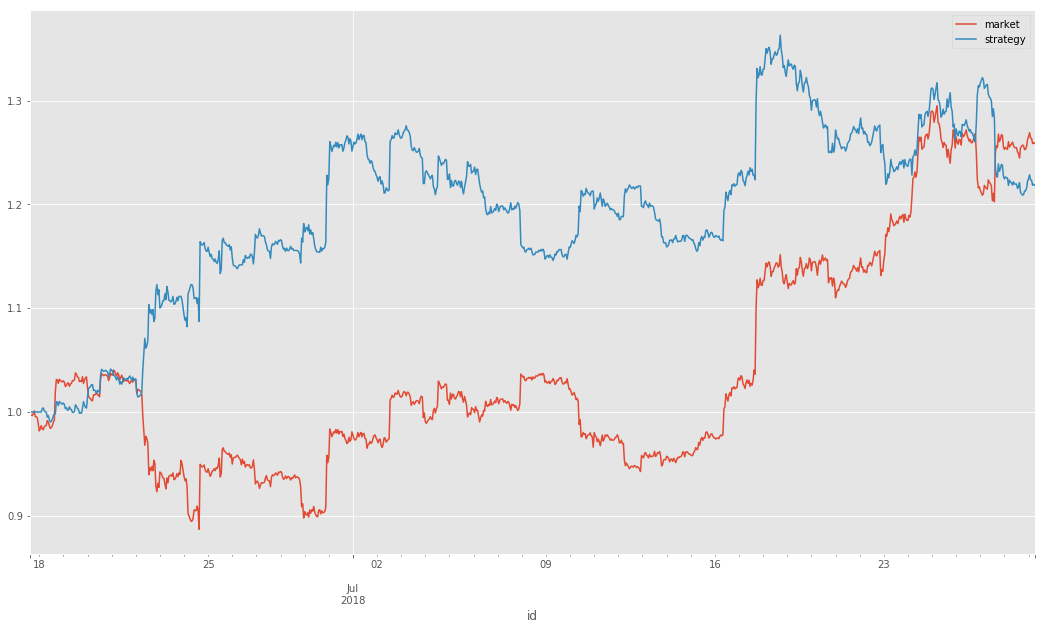

In [212]:
print("capital: " + str(capital))
records = []
for index, row in btcusdt[max(slow_period, fast_period):-1].iterrows():
    close = row['close']
    fast = row['fast_period']
    slow = row['slow_period']
    slow_deg = row['slow_deg']
    fast_deg = row['fast_deg']
    regime = row['regime']
    v_slow_deg = row['v_slow_deg']
    v_fast_deg = row['v_fast_deg']
    slow_amount_avg = row['slow_amount_avg']
    fast_amount_avg = row['fast_amount_avg']
    amount = row['amount']
    if amount > 0:
        if capital != 0: # buy
            # long down, short up
#             if (slow_deg <= slow_deg_down and fast_deg >= fast_deg_up) \
            if regime == 1:
                btcusdt.loc[index, 'commission'] = close * commission_rate
                transaction_price = close
                transaction_volume = np.round(capital*(1-commission_rate)/close, 3)
                capital = 0
                records.append(('buy', close, index, transaction_volume))
        elif capital == 0: # sell
             # long up, short down
#             if (slow_deg >= slow_deg_up and fast_deg <= fast_deg_down) \
            if regime == -1 \
                or (transaction_price*stop_loss < close):
    #             or (transaction_price*stop_win > close):
                btcusdt.loc[index, 'commission'] = close * commission_rate
                capital = transaction_volume * close * (1-commission_rate)
                transaction_price = close
                transaction_volume = 0
                records.append(('sell', close, index, transaction_volume))

if capital == 0:
    capital = transaction_price * transaction_volume
print(capital)
print("return rate: %.3f" % (capital / origin))
btcusdt['market'] = np.log(btcusdt['close'] / btcusdt['close'].shift(1))
btcusdt['strategy'] = btcusdt['regime'].shift(1) * btcusdt['market']

btcusdt[['market', 'strategy']].cumsum(skipna=True).apply(np.exp).plot(grid=True, figsize=figsize)

In [213]:
win = 0
loss = 0
b = 0
for r in records:
    if r[0] == 'buy':
        b = r[1]
    else: # sell
        if r[1] > b:
            win += 1
        else:
            loss += 1
            
print("final capital: %.2f" % capital)
print("win rate: %.3f" % (win / (win+loss)))
ret = (capital - origin) / origin
print("return: %.3f" % ret)
commission = btcusdt.commission.cumsum()[-1]
print("commssion: %.2f" % commission)

final capital: 5205.21
win rate: 0.481
return: -0.653
commssion: 7406.95


In [182]:
def plot_demo(axs=None):
    drawer = plt if axs is None else axs
    drawer.plot(btcusdt.close, c='r')
    drawer.plot(btcusdt.close.index, btcusdt.close.values + 10, c='b')
    plt.xlabel('time')
    plt.ylabel('close')
    plt.title('BTCUSDT close')
    plt.grid(True)

In [164]:
def plot_trade(buy_index, sell_index):
    start = btcusdt.index.get_loc(buy_index)
    end = btcusdt.index.get_loc(sell_index)
    plot_demo()
#     plt.fill_between(btcusdt.index, 0, btcusdt['close'], color='blue', alpha=0.08)
    if btcusdt['close'][end] < btcusdt['close'][start]:
        plt.fill_between(btcusdt.index[start:end], 0, btcusdt.close[start:end], color='red', alpha=0.8)
        is_win = False
    else:
        plt.fill_between(btcusdt.index[start:end], 0, btcusdt.close[start:end], color='green', alpha=0.8)
        is_win = True
    plt.ylim(np.min(btcusdt['close']) - 5, np.max(btcusdt['close']) + 5)
    plt.legend(['close'], loc='best')
    plt.rcParams["figure.figsize"] = (40,20)
    return is_win

In [117]:
def plot_trade_with_annotate(buy_index, sell_index):
    is_win = plot_trade(buy_index, sell_index)
    plt.annotate('stop win' if is_win else 'stop loss',
                 xy=(sell_index, btcusdt['close'].asof(sell_index)),
                 arrowprops=dict(facecolor='yellow'),
                 horizontalalignment='left',
                 verticalalignment='top')

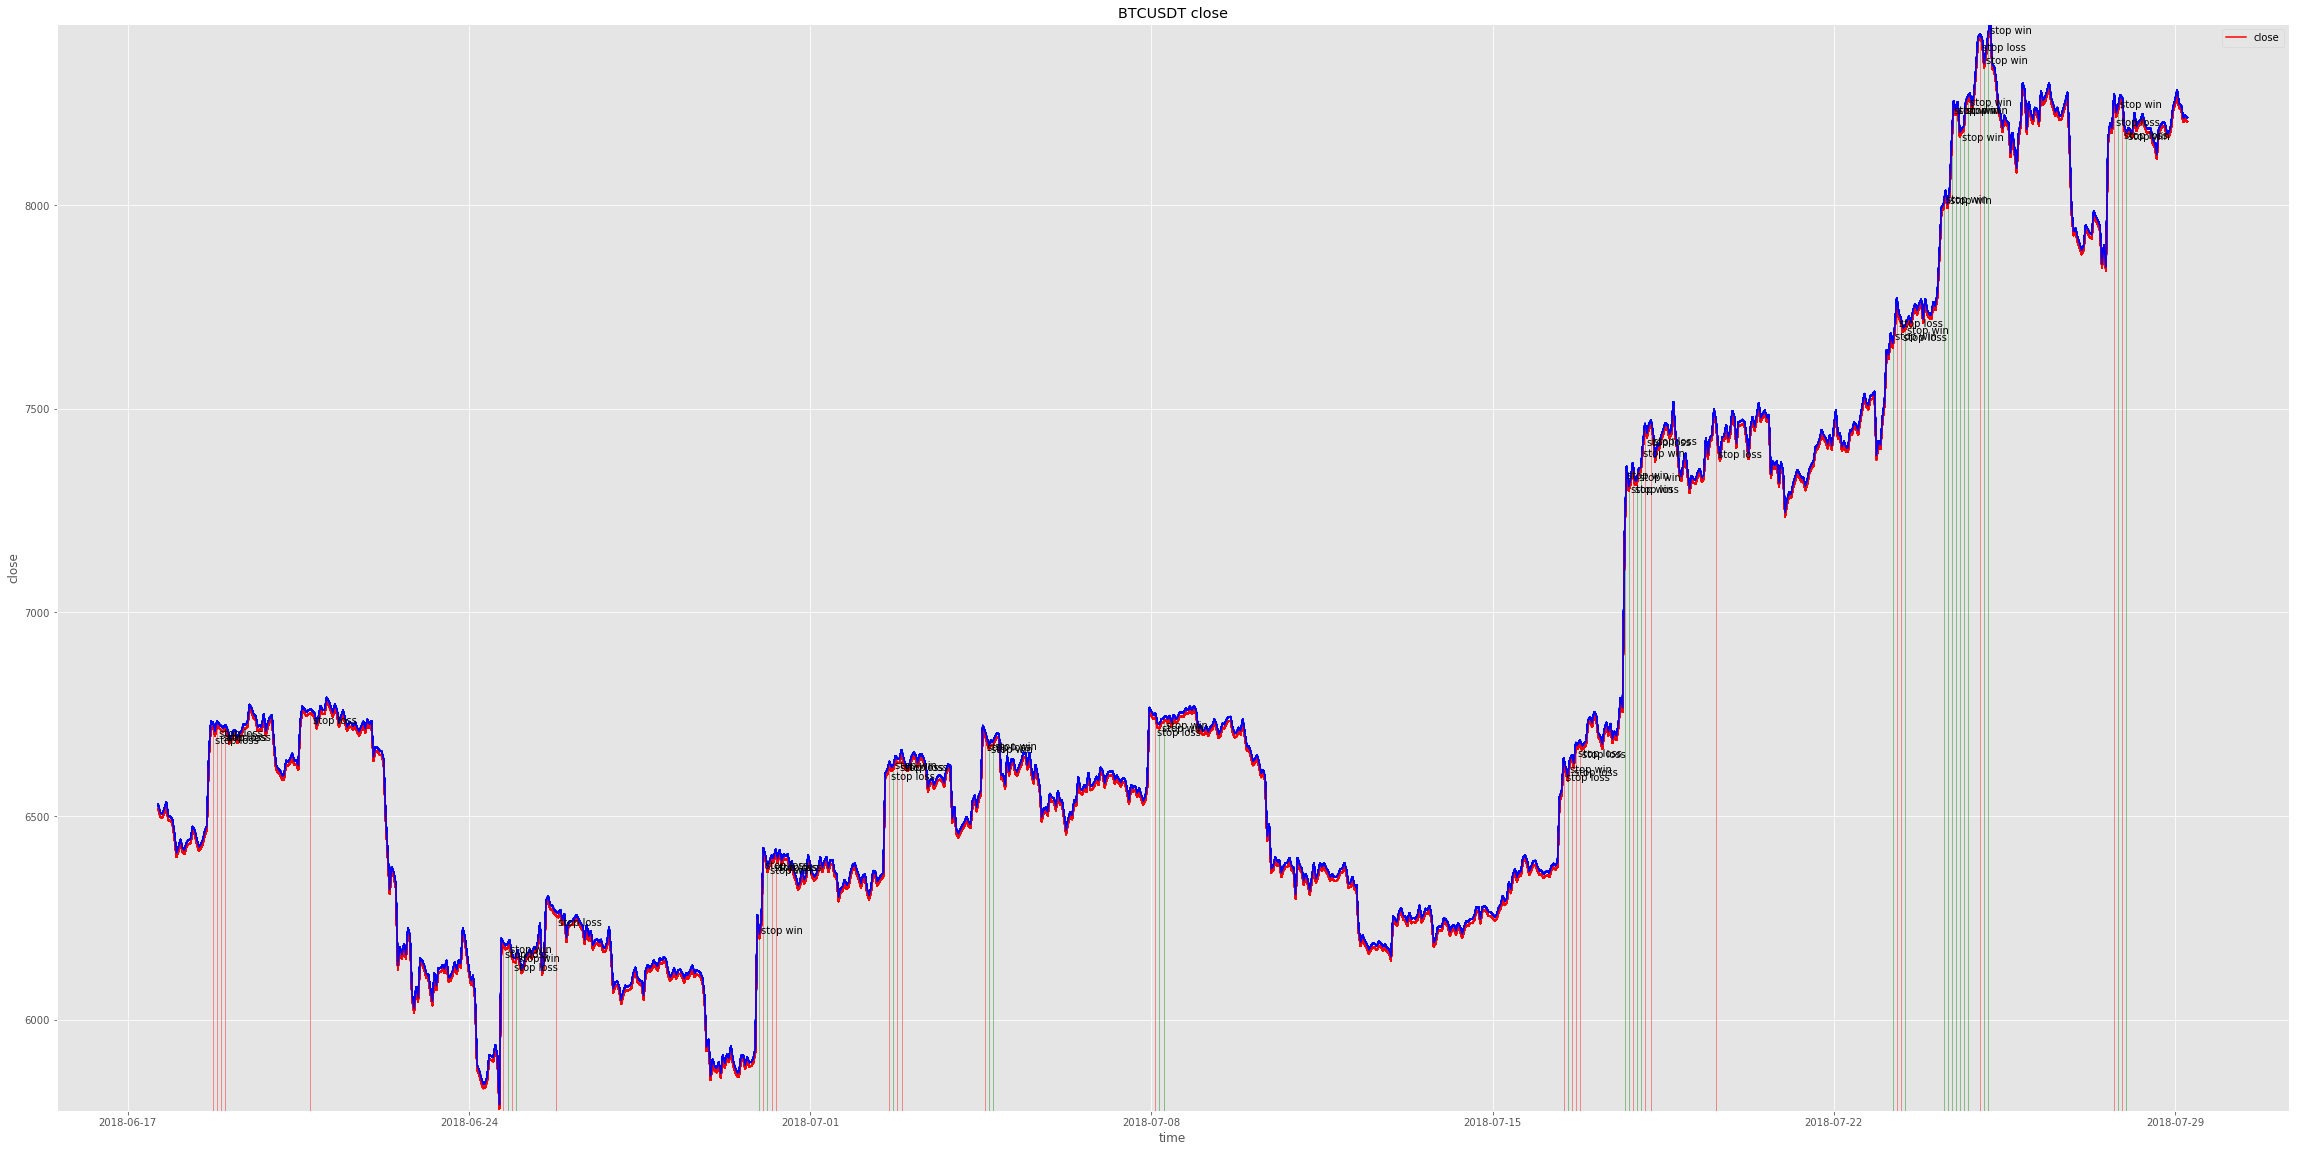

In [203]:
buys = list(filter(lambda x: x[0] == 'buy', records))
sells = list(filter(lambda x: x[0] == 'sell', records))
for i in range(min(len(buys), len(sells))):
    plot_trade_with_annotate(buys[i][2], sells[i][2])

In [166]:
for i in buys:
    print("price: %.2f, volume: %.3f, total: %.3f" % (i[1], i[3], (i[1]*i[3])))

price: 6725.16, volume: 2.225, total: 14963.481
price: 7347.91, volume: 2.166, total: 15915.573
price: 8402.37, volume: 1.914, total: 16082.136
price: 8184.03, volume: 1.891, total: 15476.001


In [32]:
records

[('buy',
  6142.9399999999996,
  Timestamp('2017-10-30 04:00:00'),
  2.4359999999999999),
 ('sell', 6162.9300000000003, Timestamp('2017-10-30 08:00:00'), 0),
 ('buy',
  6076.8999999999996,
  Timestamp('2017-10-30 12:00:00'),
  2.4609999999999999),
 ('sell', 6079.7399999999998, Timestamp('2017-10-30 16:00:00'), 0),
 ('buy',
  6115.1899999999996,
  Timestamp('2017-10-30 20:00:00'),
  2.4369999999999998),
 ('sell', 6130.0, Timestamp('2017-10-31 00:00:00'), 0),
 ('buy',
  6123.5699999999997,
  Timestamp('2017-10-31 04:00:00'),
  2.4300000000000002),
 ('sell', 6215.0, Timestamp('2017-10-31 08:00:00'), 0),
 ('buy',
  6339.6499999999996,
  Timestamp('2017-10-31 12:00:00'),
  2.3730000000000002),
 ('sell', 6327.8800000000001, Timestamp('2017-10-31 16:00:00'), 0),
 ('buy',
  6436.5299999999997,
  Timestamp('2017-10-31 20:00:00'),
  2.3239999999999998),
 ('sell', 6419.7200000000003, Timestamp('2017-11-01 00:00:00'), 0),
 ('buy', 6392.29, Timestamp('2017-11-01 04:00:00'), 2.3250000000000002),
 ('

In [79]:
btcusdt.columns

Index(['amount', 'close', 'count', 'high', 'low', 'open', 'vol', 'slow_period',
       'fast_period', 'fast_slow', 'regime', 'commission', 'slow_deg',
       'fast_deg', 'market', 'strategy'],
      dtype='object')

In [108]:
btcusdt.head(200)

,amount,close,count,high,low,open,vol,slow_period,fast_period,fast_slow,regime,commission,slow_deg,fast_deg,v_slow_deg,v_fast_deg,market,strategy
id,,,,,,,,,,,,,,,,,,
2018-02-12 16:00:00,839.811005,8787.95,8736,8788.00,8613.70,8645.00,7.297614e+06,NaN,NaN,NaN,0,0.00000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2018-02-12 20:00:00,996.958801,8893.73,9662,8960.09,8736.75,8788.00,8.845029e+06,NaN,NaN,NaN,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.011965,0.000000
2018-02-13 00:00:00,1479.868640,8754.46,12166,8931.03,8638.90,8893.73,1.296235e+07,NaN,NaN,NaN,0,0.00000,0.000000,0.000000,0.000000,0.000000,-0.015783,-0.000000
2018-02-13 04:00:00,1419.534641,8657.00,9594,8770.00,8558.00,8752.00,1.227731e+07,NaN,NaN,NaN,0,0.00000,0.000000,0.000000,0.000000,0.000000,-0.011195,-0.000000
2018-02-13 08:00:00,2597.067008,8525.73,21177,8657.90,8366.00,8652.23,2.202873e+07,NaN,8723.774,NaN,0,0.00000,0.000000,0.000000,0.000000,0.000000,-0.015280,-0.000000
2018-02-13 12:00:00,1815.516157,8484.89,19793,8679.50,8449.16,8524.74,1.552197e+07,NaN,8663.162,NaN,0,0.00000,0.000000,-1.961464,0.000000,34.743581,-0.004802,-0.000000
2018-02-13 16:00:00,1331.875600,8587.99,17705,8629.40,8475.42,8477.11,1.139833e+07,NaN,8602.014,NaN,0,0.00000,0.000000,-2.696501,0.000000,24.305960,0.012078,0.000000
2018-02-13 20:00:00,880.391159,8530.32,10406,8746.26,8478.41,8583.70,7.591214e+06,NaN,8557.186,NaN,0,0.00000,0.000000,-1.322171,0.000000,0.882429,-0.006738,-0.000000
2018-02-14 00:00:00,1155.666955,8690.00,14644,8720.00,8528.05,8532.59,1.000078e+07,NaN,8563.786,NaN,0,0.00000,0.000000,-0.505913,0.000000,-20.680471,0.018546,0.000000
